In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp

In [24]:
np.arange(1, 5, 0.001).shape

(4000,)

In [50]:
%%time
temp = stats.gamma.rvs(a=np.arange(.001, 12, 1), size=(50000, 12))

CPU times: user 40 ms, sys: 126 ms, total: 166 ms
Wall time: 166 ms


In [25]:
%%time
temp = stats.gamma.rvs(a=np.arange(1, 5, 0.001), size=(50000, 4000))

CPU times: user 10.9 s, sys: 1.54 s, total: 12.4 s
Wall time: 12.5 s


In [3]:
np.random.dirichlet([[1, 2, 3], [1, 2, 3]], 5)

ValueError: object too deep for desired array

In [27]:
def generalized_binom_coef(x,y):
    
#     if type(x) == int and type(y) == np.ndarray:
#         x = np.full_like(y, x)
#     if type(y) == int and type(y) == np.ndarray:
#         y = np.full_like(x, y)

    return sp.special.gamma(x+1) / (sp.special.gamma(y+1) * sp.special.gamma(x-y+1))

class toy_rv(stats.rv_discrete):
    
    def _pmf(self, k, n, p):
        
        return generalized_binom_coef(n, k) * p ** (k) * (1-p)**(n-k)
        

In [28]:
def naive_estimation(observed, p_hat=0.1):
    
    mu_hat = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)
    
    sigma_hat = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))

    return mu_hat, sigma_hat

In [29]:
def generate_moment_mat(size=2):
    
    B = np.zeros((size, 2))
    B[:, 0] = np.arange(size)+1
    B[:, 1] = (np.arange(size)+1)**2/2
    return B

def get_observed_moments(data, order=2):
    
    return np.array([(data**(i+1)).mean() for i in range(order)]).reshape(-1, 1)
    
    first = data.mean()
    
    second_sum = (data**2).sum()
    
    if data.max() == 1:
        
        second_sum += 2
    
    second = second_sum / data.shape[0]
    
    third = (data**3).mean()
    
    if order == 2:
        
        return np.array([first, second]).reshape(-1, 1)
    else:
        return np.array([first, second, third]).reshape(-1, 1)

def linsys_estimation(data, p=0.1, order=2, lam_max=3):
    
    if order == 3:
        A = np.zeros((3,3))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        A[2, 0] = (2*p**3 - 3*p**2 + p)
        A[2, 1] = (3*p**2 - 3*p**3)
        A[2, 2] = p**3
    else:
        A = np.zeros((2,2))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        
    #lam = (1-(data < 1).mean())
    lam = 0
    logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=order)))
    B = generate_moment_mat(size=order)
    #R = lam * np.array([1, 1]).reshape(1, -1)
    sol = np.linalg.inv(B.T.dot(B) + lam*np.eye(2)).dot(B.T).dot(logex)
    #sol = np.linalg.inv(B.T.dot(B)).dot(B.T.dot(logex) - R)
    return logex, sol[0, 0], np.sqrt(sol[1, 0])

In [30]:
mu = -8
sigma = 1.25

### Sample mu and sigma

In [31]:
np.sqrt(2)*np.sqrt(0.1)*0.9

0.4024922359499622

In [32]:
0.65238058/np.sqrt(3.76735706)/np.sqrt(0.14083737)

0.8956197863296531

In [33]:
parameter_mean = np.array([-1.22026592,  1.30844892])
cov = -.4
parameter_cov = np.array([[ 3.76735706, -0.65238058],
       [-0.65238058,  0.14083737]])

sample = stats.multivariate_normal.rvs(mean=parameter_mean, cov=parameter_cov, size=1000)

In [34]:
parameter_mean = [-1, 1.4]
cov = -.4
parameter_cov = [[2, cov], [cov, 0.1]]

sample = stats.multivariate_normal.rvs(mean=parameter_mean, cov=parameter_cov, size=1000)

Text(0.5, 1.0, 'Prior distribution of parameters')

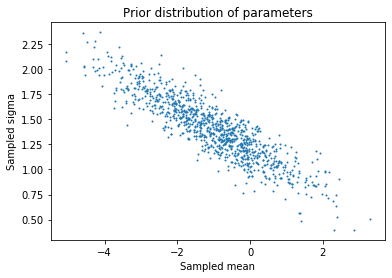

In [35]:
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.xlabel('Sampled mean');
plt.ylabel('Sampled sigma')
plt.title('Prior distribution of parameters')

In [36]:
# values_mat = np.arange(0, alpha.shape[0]).reshape(1, -1).T.dot(np.arange(0, alpha.shape[0]).reshape(1, -1))
# (np.cov(weights_1.T) * values_mat).sum()

In [37]:
def estimate_permuted_distribution(observed, frac):
    
    # Get some summaries
    counts = np.bincount(observed)
    props = counts / counts.sum()
    alpha = counts * frac
    
    # Compute the Dirichlet parameters
    dir_mean = stats.dirichlet.mean(alpha+1e-100)
    dir_var = stats.dirichlet.var(alpha+1e-100)
    dir_cov = -alpha.reshape(-1, 1).dot(alpha.reshape(1, -1))/(alpha.sum() + 1)
    np.diag(dir_cov) = dir_var
    
    
    
    
    

SyntaxError: can't assign to function call (<ipython-input-37-b7dbf07d6188>, line 12)

In [38]:
stats.dirichlet.var(alpha+1e-10)

NameError: name 'alpha' is not defined

In [39]:
alpha

NameError: name 'alpha' is not defined

In [40]:
params_1 = [1, 1]

lognorm_data_1 = stats.lognorm.rvs(
    s=params_1[1], 
    scale=np.exp(params_1[0]), 
    size=2000)

data_1 = \
    toy_rv().rvs(
        n=lognorm_data_1,
        p=0.1)

In [41]:
params_2 = [-1, 1]

lognorm_data_2 = stats.lognorm.rvs(
    s=params_2[1], 
    scale=np.exp(params_2[0]), 
    size=2000)

data_2 = \
    toy_rv().rvs(
        n=lognorm_data_2,
        p=0.1)

In [42]:
num_permutation = 50000
all_data = np.concatenate([data_1, data_2])

In [47]:
alpha.shape

(12,)

In [55]:
%%time
alpha = np.bincount(all_data)/2
values = np.tile(np.arange(0, alpha.shape[0]).reshape(1, -1), (num_permutation, 1))
weights = stats.gamma.rvs(alpha+1e-5, size=(num_permutation, alpha.shape[0]))

second_moments = ((weights) * values**2).sum(axis=1)
first_moments = ((weights) * values).sum(axis=1)
var = second_moments - first_moments**2

CPU times: user 48.5 ms, sys: 2.6 ms, total: 51.1 ms
Wall time: 51.2 ms


In [56]:
%%time
diff_means = np.zeros(num_permutation)
alpha = np.bincount(all_data)/2
values = np.tile(np.arange(0, alpha.shape[0]).reshape(1, -1), (num_permutation, 1))
weights = stats.dirichlet.rvs(alpha + 1e-11, size=num_permutation)

second_moments = ((weights) * values**2).sum(axis=1)
first_moments = ((weights) * values).sum(axis=1)
var = second_moments - first_moments**2

CPU times: user 43.6 ms, sys: 3.16 ms, total: 46.7 ms
Wall time: 47.8 ms


In [20]:
%%time
first_moments_naive = np.zeros(num_permutation)
second_moments_naive = np.zeros(num_permutation)

for i in range(num_permutation):
    
    perm_idx = np.random.permutation(all_data.shape[0])
    group_1 = np.random.choice(all_data, size=int(all_data.shape[0]/2), replace=True)
    
    first_moments_naive[i] = group_1.mean()
    second_moments_naive[i] = (group_1**2).mean()
    

CPU times: user 1.78 s, sys: 9.95 ms, total: 1.79 s
Wall time: 1.83 s


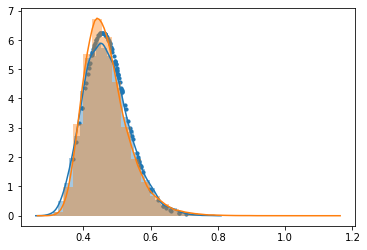

In [82]:
s, loc, scale = stats.lognorm.fit(second_moments, floc=0)
sns.distplot(second_moments_naive, bins=30)
sns.distplot(second_moments, bins=30)
sample = np.random.choice(second_moments, 100)
plt.scatter(sample, stats.lognorm.pdf(sample, s=s, loc=loc, scale=scale), s=10)




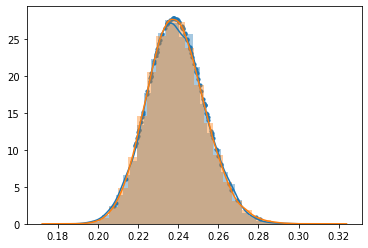

In [83]:
s, loc, scale = stats.lognorm.fit(first_moments, floc=0)
sns.distplot(first_moments_naive, bins=30)
sns.distplot(first_moments, bins=30)
sample = np.random.choice(first_moments, 100)
plt.scatter(sample, stats.lognorm.pdf(sample, s=s, loc=loc, scale=scale), s=10)



In [315]:
diff_means

array([0.024 , 0.0155, 0.0245, ..., 0.023 , 0.0235, 0.0195])

In [22]:
all_data.shape

(10000,)

In [14]:
pd.Series(data).value_counts()

0     3559
1     1016
2      268
3       83
4       39
5       19
7        5
6        5
8        3
9        2
11       1
dtype: int64

In [15]:
# The old fashioned way

In [38]:
mean_list = []
var_list = []

logmean_list = []
logvar = []

datas = []

for trial in range(1000):
    
    params = stats.multivariate_normal.rvs(mean=parameter_mean, cov=parameter_cov, size=1)
    
    mu = params[0]
    sigma = params[1]

    lognorm_data = stats.lognorm.rvs(
        s=sigma, 
        scale=np.exp(mu), 
        size=5000)

    data = \
        toy_rv().rvs(
            n=lognorm_data,
            p=0.1)

#     if data.max() == 1:

#         continue
        
    datas.append(data)

    #logex, m, v = linsys_estimation(data, order=2)
    m_naive, v_naive = naive_estimation(data)

    mean_list.append(m_naive)
    var_list.append(v_naive)

    logmean_list.append(np.exp(logex[0,0]))
    logvar.append(np.exp(logex[1,0]) - np.exp(logex[0,0])**2)

/anaconda3/envs/sc_ht/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  


In [39]:
plugin_means = [x.mean() for x in datas]
plugin_vars = [x.var() for x in datas]

In [40]:
len(plugin_means)

1000

(0, 1.5)

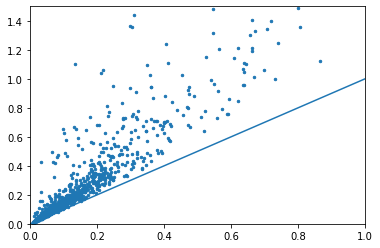

In [57]:
plt.scatter(plugin_means, plugin_vars, s=6)
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1.5)

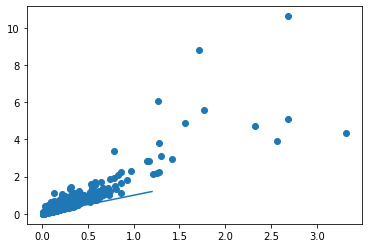

In [42]:
plt.scatter(plugin_means, plugin_vars)
plt.plot([0, 1.2], [0, 1.2])

In [44]:
stats.pearsonr(
    np.array(mean_list)[~np.isnan(np.array(mean_list))], 
    np.array(var_list)[~np.isnan(np.array(var_list))])

(-0.8600870600054129, 5.594442378799771e-294)

In [45]:
np.where(np.array(mean_list) <-3)[0]

array([ 30,  61,  79,  94, 119, 120, 122, 129, 133, 138, 143, 148, 155,
       169, 200, 213, 223, 234, 238, 244, 260, 276, 284, 289, 324, 332,
       368, 383, 410, 412, 413, 445, 448, 460, 466, 508, 560, 573, 623,
       675, 689, 691, 705, 715, 744, 772, 773, 777, 787, 794, 813, 814,
       831, 861, 878, 915, 961, 966, 970, 973, 997, 999])

In [46]:
mean_list[67]

-1.7426710070279088

In [47]:
var_list[67]

1.5179462538529191

(array([4.766e+03, 0.000e+00, 2.050e+02, 0.000e+00, 2.000e+01, 0.000e+00,
        5.000e+00, 0.000e+00, 3.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

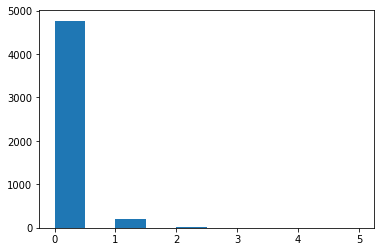

In [48]:
plt.hist(datas[67])

In [49]:
np.array(mean_list).mean()

-0.9525372558259892

In [50]:
np.sqrt(np.array(var_list)).mean()

1.163499517809838

In [51]:
np.cov(mean_list, np.sqrt(np.array(var_list)).T)

array([[ 1.82051174, -0.14937503],
       [-0.14937503,  0.01650684]])

(0.4, 2.5)

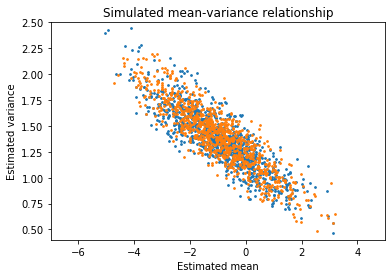

In [56]:
plt.scatter(mean_list, np.array(var_list), s=3)
plt.scatter(sample[:, 0], sample[:, 1], s=3)

plt.title('Simulated mean-variance relationship')
plt.xlabel('Estimated mean');
plt.ylabel('Estimated variance');
plt.xlim(-7,5, 7.5);
plt.ylim(0.4, 2.5)

### Keep sigma constant

In [150]:
mean_list = []
var_list = []

naive_mean_list = []
naive_var_list = []

logmean_list = []
logvar = []

datas = []

mus = np.arange(-3, 2, 0.05)
for mu in mus:
    
    print(mu)

    lognorm_data = stats.lognorm.rvs(
        s=sigma, 
        scale=np.exp(mu), 
        size=1000)

    data = \
        toy_rv().rvs(
            n=lognorm_data,
            p=0.1)

    #if data.sum() == 0:

        #continue
        
    datas.append(data)

    logex, m, v = linsys_estimation(data, order=2)
    m_naive, v_naive = naive_estimation(data)

    mean_list.append(m)
    var_list.append(v)

    naive_mean_list.append(m_naive)
    naive_var_list.append(v_naive)

    logmean_list.append(np.exp(logex[0,0]))
    logvar.append(np.exp(logex[1,0]) - np.exp(logex[0,0])**2)

-3.0
-2.95
-2.9000000000000004
-2.8500000000000005
-2.8000000000000007
-2.750000000000001
-2.700000000000001
-2.6500000000000012
-2.6000000000000014
-2.5500000000000016
-2.5000000000000018
-2.450000000000002
-2.400000000000002
-2.3500000000000023
-2.3000000000000025
-2.2500000000000027
-2.200000000000003
-2.150000000000003
-2.100000000000003
-2.0500000000000034
-2.0000000000000036
-1.9500000000000037
-1.900000000000004
-1.850000000000004
-1.8000000000000043
-1.7500000000000044
-1.7000000000000046
-1.6500000000000048
-1.600000000000005
-1.5500000000000052
-1.5000000000000053
-1.4500000000000055
-1.4000000000000057
-1.3500000000000059
-1.300000000000006
-1.2500000000000062
-1.2000000000000064
-1.1500000000000066
-1.1000000000000068
-1.050000000000007
-1.000000000000007
-0.9500000000000073
-0.9000000000000075
-0.8500000000000076
-0.8000000000000078
-0.750000000000008
-0.7000000000000082
-0.6500000000000083
-0.6000000000000085
-0.5500000000000087
-0.5000000000000089
-0.45000000000000906
-0

/anaconda3/envs/sc_ht/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
/anaconda3/envs/sc_ht/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


1.4499999999999842
1.499999999999984
1.5499999999999838
1.5999999999999837
1.6499999999999835
1.6999999999999833
1.7499999999999831
1.799999999999983
1.8499999999999828
1.8999999999999826
1.9499999999999824


In [151]:
logmeans = np.exp(mus + sigma**2/2)
logvars = (np.exp(sigma**2) - 1)*np.exp(2*mus + sigma**2)

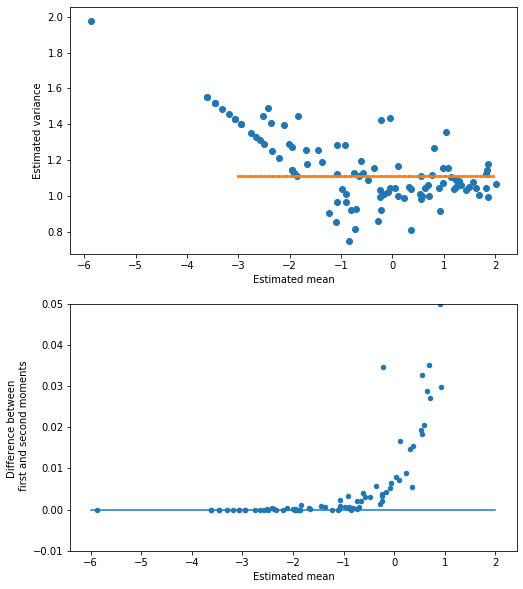

In [156]:
#plt.scatter(mean_list, var_list)

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.scatter(naive_mean_list, naive_var_list)
plt.scatter(mus, np.ones(mus.shape[0])*sigma, s=5)
plt.xlabel('Estimated mean');
plt.ylabel('Estimated variance');

plt.subplot(2, 1, 2)
plt.scatter(naive_mean_list, 0.1*np.array([(x**2).mean() - x.mean() for x in datas]), s=20)
plt.plot([-6, 2], [0, 0])
plt.ylim(-0.01, 0.05)
plt.xlabel('Estimated mean');
plt.ylabel('Difference between \n first and second moments');

In [141]:
m_naive

-5.259836845979974

In [142]:
v_naive

1.872580544948597

In [143]:
m

-3.5550995689374583

In [144]:
v

1.2665649101207372

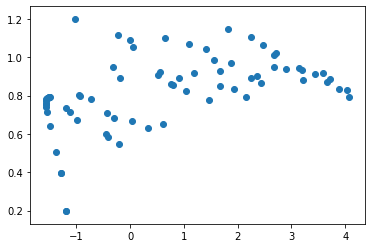

In [109]:
plt.scatter(mean_list, var_list)

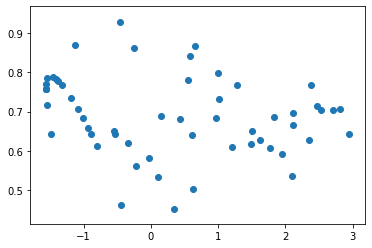

In [80]:
plt.scatter(mean_list, var_list)

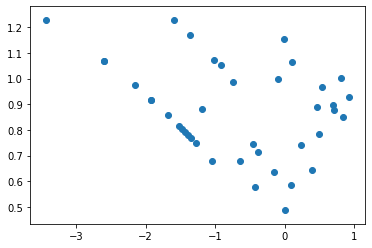

In [16]:
plt.scatter(mean_list, var_list)

In [9]:
stats.pearsonr(mean_list, var_list)

(-0.9993538930605612, 1.85897840425904e-27)

In [126]:
logex

array([[-2.46510402],
       [-2.46510402],
       [-2.46510402]])

In [127]:
np.log(get_observed_moments(lognorm_data, order=3))

array([[-2.53959438],
       [-4.08222804],
       [-4.59734322]])

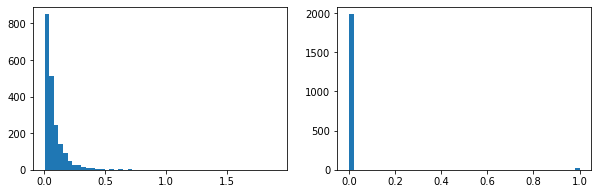

In [128]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
plt.hist(lognorm_data, bins=50);
plt.subplot(1, 2, 2);
plt.hist(data, bins=50);

In [384]:
logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=3)))

In [57]:
np.array([(x**2).mean() - x.mean() for x in datas]).shape

(100,)

In [58]:
logmeans.shape

(100,)

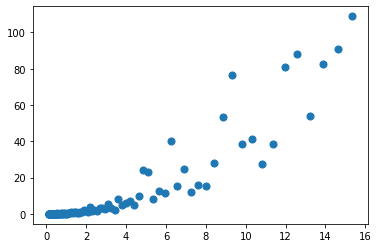

In [59]:
#plt.scatter([x.mean() for x in datas], [(x**2).mean() for x in datas])
plt.scatter(logmeans, 10*np.array([(x**2).mean() - x.mean() for x in datas]), s=50)
#plt.xlim(0, 2);
#plt.ylim(-0.001, 0.01)
#plt.plot([0, 1], [0, 1])
#plt.ylim(0, 0.05);plt.xlim(0, 0.05)

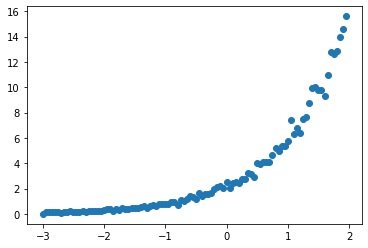

In [60]:
plt.scatter(mus, logmean_list)
#plt.plot([-4, 2], [0.75, 0.75])

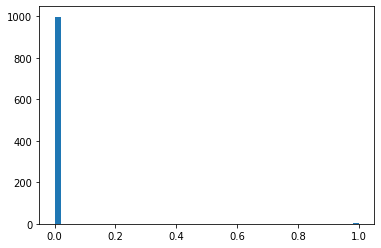

In [61]:
plt.hist(datas[0], bins=50);

(0, 0.5)

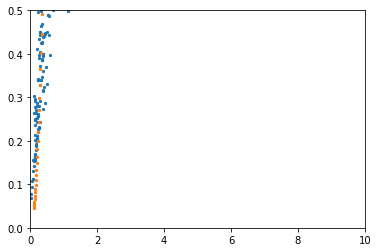

In [139]:
plt.scatter(logmean_list, logvar, s=5)
plt.scatter(logmeans, logvars, s=5)
#plt.scatter(logmeans, 20*np.array([(x**2).mean() - x.mean() for x in datas]), s=20)
# #plt.scatter(logmeans, [(x**2).mean() - x.mean() for x in datas], s=5)
plt.xlim(0, 10);
plt.ylim(0, 0.5)

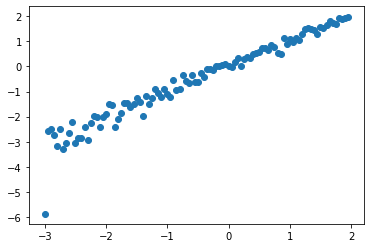

In [63]:
plt.scatter(mus, mean_list)

In [64]:
stats.linregress(logmeans, logmean_list)

LinregressResult(slope=0.9985521120486357, intercept=0.006523777398456776, rvalue=0.9968716382451833, pvalue=7.838650910122967e-110, stderr=0.007997458863059312)

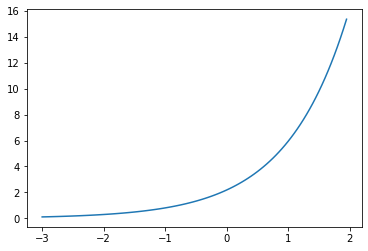

In [65]:
plt.plot(mus, logmeans)

In [385]:
logex

array([[1.37371558],
       [3.5931942 ],
       [1.51583028]])

In [386]:
np.log(get_observed_moments(lognorm_data, order=3))

array([[1.46499602],
       [3.8641409 ],
       [6.92191514]])

In [9]:
def generate_moment_mat(size=2):
    
    B = np.zeros((size, 2))
    B[:, 0] = np.arange(size)+1
    B[:, 1] = (np.arange(size)+1)**2/2
    return B

def get_observed_moments(data, order=2):
    
    return np.array([(data**(i+1)).mean() for i in range(order)]).reshape(-1, 1)

def linsys_estimation(data, p=0.1, order=2, lam=0.1):
    
    if order == 3:
        A = np.zeros((3,3))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2
        A[2, 0] = (2*p**3 - 3*p**2 + p)
        A[2, 1] = (3*p**2 - 3*p**3)
        A[2, 2] = p**3
    else:
        A = np.zeros((2,2))
        A[0, 0] = p
        A[1, 0] = -p*(p-1)
        A[1, 1] = p**2    
    
    logex = np.log(np.linalg.inv(A).dot(get_observed_moments(data, order=order)))
    B = generate_moment_mat(size=order)
    R = lam * np.array([1, -1]).reshape(1, -1)
    #sol = np.linalg.inv(B.T.dot(B) + R.T.dot(R)).dot(B.T).dot(logex)
    sol = np.linalg.inv(B.T.dot(B)).dot(B.T.dot(logex) - R)
    return np.exp(logex), sol[0, 0], np.sqrt(sol[1, 0])

In [536]:
linsys_estimation(data, order=3)

(-5.124135468723669, 1.5635940693408688)

In [133]:
n = 5
p = 0.1

In [157]:
stats.binom.expect(lambda x: x**3, args=(n,p))

1.1599999999999997

In [158]:
n**2*(p**2) - n*p*(p-1)

0.7000000000000001

In [161]:
n**3*p**3 + n**2*(3*p**2 - 3*p**3) + n*(2*p**3 - 3*p**2 + p)

1.1600000000000001